
# Nonlinear equations

In [1]:
from functools import partial

import pandas as pd
import numpy as np


from algorithms_nonlinear import bisect
from plots_nonlinear import plot_bisect_example

from algorithms_nonlinear import fixpoint
from plots_nonlinear import plot_fixpoint_example

from algorithms_nonlinear import newton_method
from problems_nonlinear import get_cournot_problem

from algorithms_nonlinear import mcp_minmax, mcp_fisher
from problems_nonlinear import get_mcp_problem
from problems_nonlinear import get_spacial_market
from problems_nonlinear import get_fischer_problem

from scipy.optimize import root

## Bisection method

We can start with some special cases to develop the basic building blocks for more complicated material

In [2]:
def f(x):
    return x ** 3 - 2


a, b = 1, 2
bisect(f, a, b)

1.259921059012413

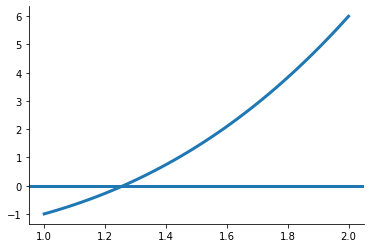

In [3]:
plot_bisect_example(f, a, b)

## Function iteration

In [4]:
def f(x):
    return np.sqrt(x)


fixpoint(f, 2)

1.0000846162726942

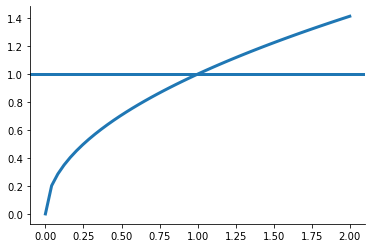

In [5]:
plot_fixpoint_example(f)

## Newton's method

In [6]:
def f(x):
    return x ** 3 - 2, 3 * x ** 2


newton_method(f, np.array([1.0]))

array([1.25992105])

In [7]:
c, e = np.array([0.6, 0.8]), 1.6
cournot_p = partial(get_cournot_problem, c, e)

newton_method(cournot_p, np.array([0.2, 0.2]))

array([0.8395676 , 0.68879643])

## Quasi-Newton methods

In [8]:
c, e = np.array([0.6, 0.8]), 1.6
cournot_p = partial(get_cournot_problem, c, e, jac=False)

root(cournot_p, np.array([0.8, 0.2]), method="broyden1")

     fun: array([4.86631603e-07, 7.63014862e-07])
 message: 'A solution was found at the specified tolerance.'
     nit: 6
  status: 1
 success: True
       x: array([0.83956711, 0.68879583])

In [9]:
cournot_p = partial(get_cournot_problem, c, e)
newton_method(cournot_p, np.array([0.2, 0.2]))

array([0.8395676 , 0.68879643])

## Convergence rates

## Benchmarking exercise

We now consider a more challenging task and compare the performance of `scipy`'s root finding algorithms.

In [10]:
def exponential_function(x):

    p = x.shape[0]
    rslt = np.tile(np.nan, p)

    for i in range(p):
        if i == 0:
            rslt[i] = np.exp(x[i]) - 1
        else:
            rslt[i] = (i / 10) * (np.exp(x[i]) + x[i - 1] - 1)

    return rslt


METHODS = ["broyden1", "broyden2", "anderson", "Krylov"]

OPTIONS = dict()
OPTIONS["maxiter"] = 500

DIMENSION = 10

In [11]:
df = pd.DataFrame(columns=["Algorithm", "Sample", "Success", "Iteration"])

In [12]:
counter = 0
options = dict()
for method in METHODS:

    summary = dict()
    summary["sccess"] = 0
    for _ in range(10):

        counter += 1
        x0 = np.random.uniform(size=DIMENSION)

        try:
            rslt = root(exponential_function, x0, method=method, options=options,)
        except OverflowError:
            rslt = dict()
            rslt["success"] = False
            rslt["nit"] = OPTIONS["maxiter"]

        summary["sccess"] += rslt["success"]

        df.loc[counter] = [method, _, rslt["success"], rslt["nit"]]

/home/anmearge/bin/anaconda3/envs/ose-course-scientific-computing/lib/python3.8/site-packages/scipy/optimize/nonlin.py:1001: RuntimeWarning: invalid value encountered in true_divide
  d = v / vdot(df, v)
<ipython-input-10-09378506524e>:10: RuntimeWarning: overflow encountered in exp
  rslt[i] = (i / 10) * (np.exp(x[i]) + x[i - 1] - 1)
/home/anmearge/bin/anaconda3/envs/ose-course-scientific-computing/lib/python3.8/site-packages/scipy/optimize/nonlin.py:1001: RuntimeWarning: divide by zero encountered in true_divide
  d = v / vdot(df, v)
/home/anmearge/bin/anaconda3/envs/ose-course-scientific-computing/lib/python3.8/site-packages/scipy/optimize/nonlin.py:771: RuntimeWarning: invalid value encountered in multiply
  self.collapsed += c[:,None] * d[None,:].conj()


## Nonlinear complementarity problems

In [13]:
x0 = np.array([0.5, 0.5])
a, b = np.array([[0.0, 0.0], [1.0, 1.0]])
mcp_minmax(get_mcp_problem, x0, a, b)

     fun: array([-9.47642148e-08, -1.08316782e-07])
 message: 'A solution was found at the specified tolerance.'
     nit: 11
  status: 1
 success: True
       x: array([0.79370057, 1.00000011])

## Here I get different values for x than in the presentations, but the implied quantities and prices are the same.

In [14]:
a = np.zeros(9)
b = np.full(9, np.inf)
x0 = np.zeros(9)
x_sol = mcp_minmax(get_spacial_market, x0, a, b)
quantities = x_sol["x"].reshape(3, 3).round(4)

In [15]:
if True:
    A = np.array
    as_ = A([9, 3, 18])
    bs = A([1, 2, 1])
    ad = A([42, 54, 51])
    bd = A([2, 3, 1])
    c = A([[0, 3, 9], [3, 0, 3], [6, 3, 0.0]])

prices = as_ + bs * quantities.sum(0)
prices

array([24., 27., 30.])

In [16]:
exports = quantities.sum(0) - quantities.sum(1)

In [17]:
a = np.zeros(1)
# need to make robust
b = np.full(1, np.inf)
x0 = np.zeros(1)

x_sol = mcp_minmax(get_fischer_problem, x0, a, b)
print("Minmax", x_sol)

x_sol = mcp_fisher(get_fischer_problem, x0, a, b)
print("Fisher", x_sol)

Minmax      fun: array([0.01710019])
 message: 'The maximum number of iterations allowed has been reached.'
     nit: 500
  status: 2
 success: False
       x: array([0.00355642])
Fisher      fun: array([-7.74207365e-11])
 message: 'A solution was found at the specified tolerance.'
     nit: 333
  status: 1
 success: True
       x: array([2.00498756])
